In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [4]:
quadh_index = eightb.get_quadH_pairings()

In [5]:
to_cc = lambda array : '{'+','.join(map(str,array))+'}'
jets = list(range(8))
all_pairs = [ (j0,j1) for j0 in jets for j1 in jets[j0+1:] ]
# print(',\n'.join(map(to_cc,all_pairs)))
# print(',\n'.join(map(to_cc,quadh_index)))

In [12]:
signal_tree = Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)
signal_tree = EventFilter('nfound all',nfound_all=8).filter(signal_tree)
bkg_tree = Tree(fc.eightb.preselection.QCD_B_List)

treeiter = TreeIter([signal_tree,bkg_tree])

In [13]:
treeiter = EventFilter('8jets',n_jet_emin=8).filter(treeiter)
# treeiter = TreeIter(treeiter.subset(nentries=100000,randomize=True))

In [15]:
eightb.select_topbtag(treeiter[0],True)

In [16]:
eightb.select_topbtag(treeiter[1])

In [17]:
signal,bkg= treeiter
signal_dijets = get_collection(signal,'dijet',False)
bkg_dijets = get_collection(bkg,'dijet',False)

In [18]:
quadH_ms = signal_dijets.m[:,quadh_index]
bkg_ms = bkg_dijets.m[:,quadh_index]

In [19]:
quadH_ms_ptorder = quadH_ms[ak.argsort(-signal_dijets.pt[:,quadh_index],axis=-1)]
bkg_ms_ptorder = bkg_ms[ak.argsort(-bkg_dijets.pt[:,quadh_index],axis=-1)]
signal_ms_ptorder = signal.gen_higgs_reco_m[ak.argsort(-signal.gen_higgs_reco_pt,axis=-1)]

# Minimum Mass Spread

In [20]:
def mass_spread(array):
    mean = ak.mean(array,axis=-1)
    maxim,minim = ak.max(array,axis=-1),ak.min(array,axis=-1)
    return (maxim-minim)/mean

In [21]:
signal_dms = mass_spread(signal_ms_ptorder)

In [22]:
nevents = ak.size(signal_dijets,axis=0)

In [23]:
quadH_dms = mass_spread(quadH_ms_ptorder)
bkg_dms = mass_spread(bkg_ms_ptorder)

In [24]:
best_quadH = ak.argmin(quadH_dms,axis=-1)
best_bkg = ak.argmin(bkg_dms,axis=-1)

In [25]:
best_quadH_ms = ak.Array([ ms[index] for index,ms in zip(best_quadH,quadH_ms_ptorder) ])
best_bkg_ms = ak.Array([ ms[index] for index,ms in zip(best_bkg,bkg_ms_ptorder) ])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

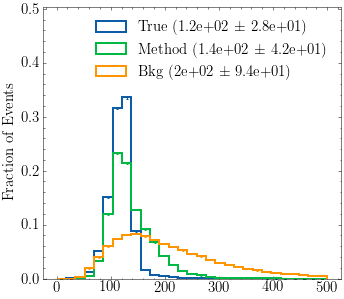

In [35]:
hist_multi([signal_ms_ptorder,best_quadH_ms,best_bkg_ms],labels=['True','Method','Bkg'],s_label_stat='mean_stdv',bins=np.linspace(0,500,30),density=True)

In [30]:
treeiter.extend(kwargs = lambda t : build_collection(t,'H\dY\d','higgs'))

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

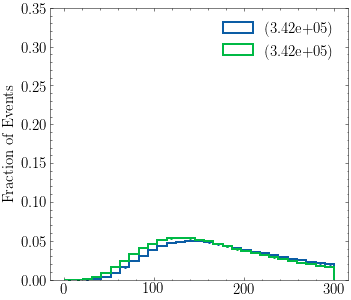

In [34]:
hist_multi([best_bkg_ms,bkg.higgs_m],bins=np.linspace(0,300,30),ylim=(0,0.35),density=1)

# Gaussian Mixture

In [ ]:
from sklearn.mixture import GaussianMixture 

gm = GaussianMixture(n_components=1).fit(signal_ms_ptorder,y=1)

In [ ]:
quadH_ms_scores = gm.score_samples(quadH_ms_ptorder.to_numpy().reshape(-1,4)).reshape(-1,105)
bkg_ms_scores = gm.score_samples(bkg_ms_ptorder.to_numpy().reshape(-1,4)).reshape(-1,105)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
best_quadH = quadH_ms_scores.argmax(axis=-1)
best_bkg = bkg_ms_scores.argmax(axis=-1)

In [ ]:
best_quadH_ms = ak.Array([ ms[index] for index,ms in zip(best_quadH,quadH_ms_ptorder) ])
best_bkg_ms = ak.Array([ ms[index] for index,ms in zip(best_bkg,bkg_ms_ptorder) ])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

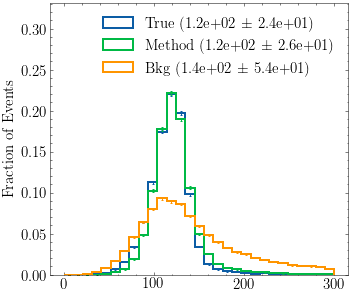

In [ ]:
hist_multi([signal_ms_ptorder,best_quadH_ms,best_bkg_ms],labels=['True','Method','Bkg'],s_label_stat='mean_stdv',bins=np.linspace(0,300,30),density=True)

# Linear Regression

In [27]:
from sklearn.linear_model import LinearRegression

linear = LinearRegression(fit_intercept=False).fit(signal_ms_ptorder,np.ones((nevents,)))

In [28]:
quadH_ms_scores = (linear.predict(quadH_ms_ptorder.to_numpy().reshape(-1,4)).reshape(-1,105)-1)**2
# bkg_ms_scores = (linear.predict(bkg_ms_ptorder.to_numpy().reshape(-1,4)).reshape(-1,105)-1)**2

In [29]:
quadH_ms_scores

array([[2.4530432e-01, 2.2764046e-01, 1.9860609e-02, ..., 4.6313994e-02,
        1.8303910e-01, 1.2434608e-01],
       [1.2816326e-01, 2.7546716e-01, 3.9103013e-01, ..., 2.7203721e-01,
        1.4353977e-01, 2.9724902e-01],
       [1.0842792e-01, 8.4554575e-02, 1.9398797e-01, ..., 3.1737339e-01,
        4.1093484e-01, 6.3382590e-01],
       ...,
       [1.3224658e-01, 1.0002543e-01, 3.0334002e-01, ..., 2.2378792e-01,
        1.8759625e-01, 6.4995289e-01],
       [1.4311988e-02, 3.4947082e-02, 4.3547605e-04, ..., 4.0305633e-02,
        1.6805109e-01, 1.5937661e-01],
       [6.7865485e-01, 2.5891095e-01, 6.7907047e-01, ..., 2.7930680e-01,
        1.4724885e-01, 3.5297194e-01]], dtype=float32)

In [30]:
best_quadH = quadH_ms_scores.argmin(axis=-1)
# best_bkg = bkg_ms_scores.argmin(axis=-1)

In [31]:
best_quadH_ms = ak.Array([ ms[index] for index,ms in zip(best_quadH,quadH_ms_ptorder) ])
# best_bkg_ms = ak.Array([ ms[index] for index,ms in zip(best_bkg,bkg_ms_ptorder) ])

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

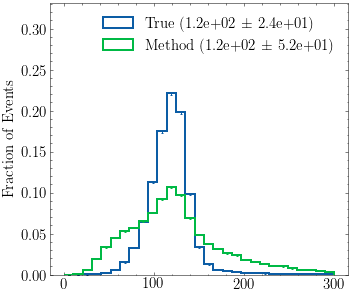

In [32]:
hist_multi([signal_ms_ptorder,best_quadH_ms],labels=['True','Method','Bkg'],s_label_stat='mean_stdv',bins=np.linspace(0,300,30),density=True)